# Prelim Exploration 01

Wayne H Nixalo

Kaggle Statoil Iceberg Satellite Imagery Classification Challenge

21 Jan 2018

## 1. Loading Data & Initializing a Learner

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

from sklearn import metrics

import json

In [3]:
PATH = 'data/'

In [4]:
with open(PATH + 'train.json') as jfile:
    train_data = json.load(jfile)

In [5]:
def array_to_np_band(data_array, key=None):
    """Returns an (n,75,75,1) ndarray from Statoil radar bands"""
    if key==None:
        print("Error: Key not specified")
        return
    return np.expand_dims(np.array([np.array(band[key]).astype(np.float32).reshape(75,75) for 
                     band in data_array]), axis=-1)

In [38]:
train_band_1 = array_to_np_band(train_data, 'band_1')
train_band_2 = array_to_np_band(train_data, 'band_2')
train_band_z = np.zeros(train_band_1.shape).astype(np.float32)

train_bands = np.concatenate([train_band_1, train_band_2, train_band_z], axis=-1)

In [58]:
labels  = np.array([datum['is_iceberg'] for datum in train_data])
train_ids = np.array([datum['id'] for datum in train_data])

In [59]:
n = len(labels)
val_idxs = get_cv_idxs(n)
val_idxs = np.array(val_idxs)

Note, thankfully, both methods seem to work.

In [60]:
# by deletion:
# train_array = (np.delete(train_bands, val_idxs, axis=0), np.delete(labels, val_idxs))
# val_array   = (train_bands[val_idxs], labels[(val_idxs)])
# ids & labels are handled later using val_idxs I guess.

# by masking:
((val_ids,trn_ids),
 (val_data_array, trn_data_array),
 (val_y,trn_y)) = split_by_idx(val_idxs, train_ids, train_bands, labels)

train_array = (trn_data_array, trn_y)
val_array   = (val_data_array, val_y)

In [61]:
sz = 75
bs = 32
f_model = resnet34
PATH = 'data/'
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
data = ImageClassifierData.from_arrays(PATH, train_array, val_array, tfms=tfms, bs=bs, 
                                       num_workers=8, classes=['0','1'], test=None)

In [62]:
learner = ConvLearner.pretrained(f_model, data, precompute=False)

In [65]:
learner.summary

<bound method ConvLearner.summary of Sequential(
  (0): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 90%|█████████ | 37/41 [00:02<00:00, 13.13it/s, loss=5.02] 


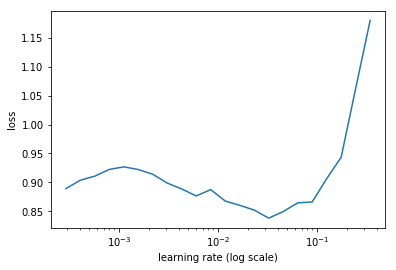

In [67]:
learner.lr_find()
learner.sched.plot()

## 2. How to separate the ConvNet & FullNet

Here's what I want to do

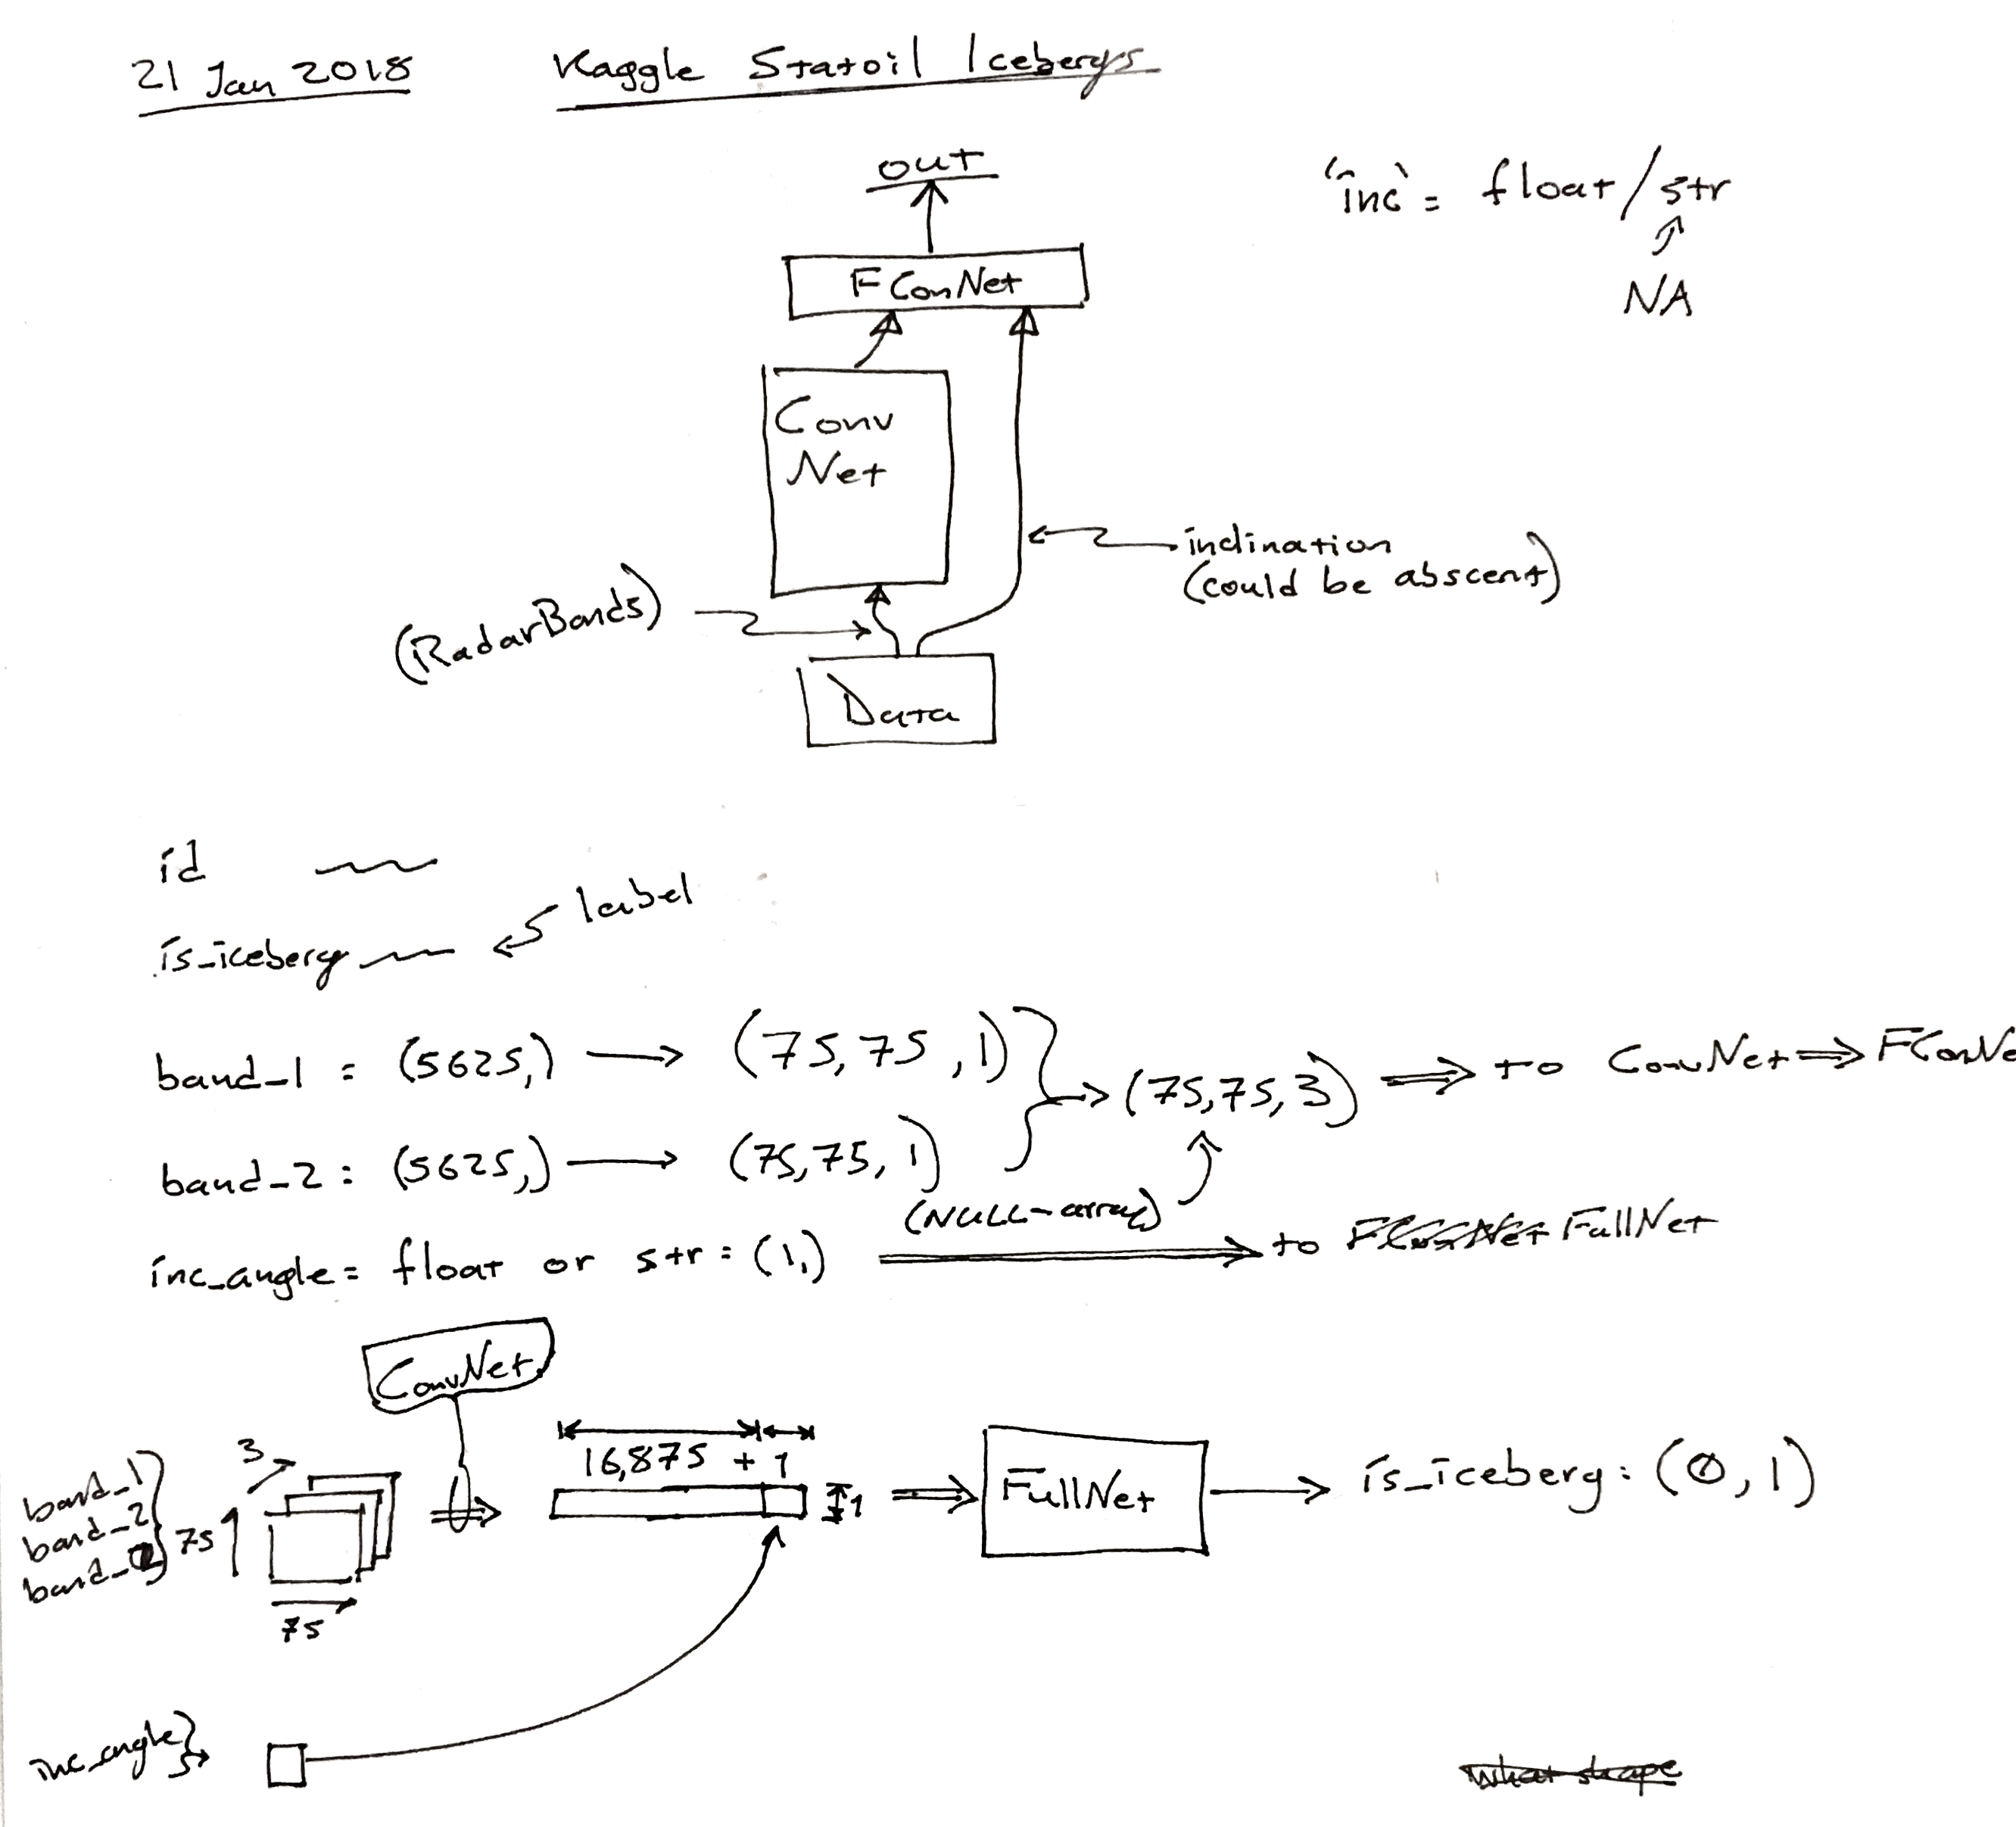

I want to use the ConvNet as a feature extractor. I want to tack-on the inclination angle number to the end of the ConvNet's output vector, and send that into a FullNet to be classified.

Okay.. Finding out how to cut off the FullNet portion of the pretrained model isn't that hard (the Fast.ai pretrained model is fully-Conv, so the FullNet is just added on top), but... how do I get a loss function going to do SGDR/backprop? ie: how do I update the weights?

I'm not sure there's a FastAI thing for that... I think I have to do it via PyTorch... but manually? What about all the automatic features in FastAI? hmm..